In [15]:
from bs4 import BeautifulSoup
import requests
from urllib.parse import urljoin
import os
import csv

In [16]:
class Crawler:
    """
    A web crawler class to fetch and process web pages, extract content,
    and save the data in a single CSV file.

    Attributes:
        baseUrl (str): The base URL for the crawler to start crawling.
        keywords (list): A list of keywords to filter relevant content.
        header (dict): HTTP headers to mimic a browser request.
        _exclude (list): URL patterns to exclude during crawling.
        _visited (set): A set to keep track of visited URLs.
        queue (list): A queue of URLs to be crawled.
        _data_loc (str): Directory to save the extracted data.
    """
    def __init__(self, baseUrl: str = None, keywords: list = None):
        """
        Initializes the Crawler class with optional base URL and keywords.

        Args:
            baseUrl (str): The base URL for crawling.
            keywords (list): Keywords to filter relevant web pages.
        """
        self.baseUrl = baseUrl
        self.header = {
            "accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
            "accept-encoding": "gzip, deflate, br",
            "accept-language": "en-US,en;q=0.9",
            "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/131.0.0.0 Safari/537.36",
            "connection": "keep-alive",
            "cache-control": "no-cache",
        }
        self._exclude = [
            "section", "for-authors",
            "editorial-board", "about", "issues",
            "posts", "toggle", "view=desktop", "search","login","signup", "account","spanish"
        ]
        self._keywords = keywords or [
            "healthcare", "health", "hospital", "clinic", "emergency", "primary care",
            "disease", "infection", "symptoms", "diagnosis", "treatment", "therapy",
            "chronic", "acute", "mental health", "cancer", "diabetes", "cardiology",
            "clinical trial", "meta-analysis", "systematic review", "case study",
            "epidemiology", "randomized controlled trial", "biostatistics",
            "nutrition", "exercise", "stress", "prevention", "self-care", "fitness",
            "vaccination", "immunization", "screening",
            "health policy", "public health", "health reform", "universal healthcare",
            "insurance", "health equity", "pandemic", "quarantine", "outbreak"
        ]
        self._visited = set()  # Tracks visited URLs
        self.queue = []  # Queue for URLs to crawl
        self._data_loc = "./data/"  # Directory to save output data
        os.makedirs(self._data_loc, exist_ok=True)

    def _crawl(self, currUrl: str = None):
        """
        Fetch a webpage and return its BeautifulSoup object.

        Args:
            currUrl (str): The URL of the webpage to crawl.

        Returns:
            BeautifulSoup: A parsed HTML page, or None if an error occurs.
        """
        try:
            page = requests.get(currUrl, headers=self.header)
            page.raise_for_status()  # Raise an HTTP error for bad responses
        except requests.exceptions.RequestException as e:
            print(f"Error fetching {currUrl}: {e}")
            return None
        soup = BeautifulSoup(page.text, 'html.parser')

        # Add links from the current page to the queue for further crawling
        for link in soup.find_all('a', href=True):
            fullUrl = urljoin(currUrl, link['href'])
            if fullUrl not in self._visited and fullUrl.startswith("http") and not any(keyword in fullUrl for keyword in self._exclude):
                self._visited.add(fullUrl)
                self.queue.append(fullUrl)

        return soup

    def crawl_n(self, n: int, output_file: str):
        """
        Crawl 'n' documents and save all data to a single CSV file.

        Args:
            n (int): Number of documents to crawl and save.
            output_file (str): Path to the output CSV file.
        """
        count = 0
        data = []  # Store all crawled data

        while count < n and self.queue:
            currUrl = self.queue.pop(0)
            print(f"Crawling: {currUrl}")

            soup = self._crawl(currUrl)
            if not soup:
                continue

            # Extract the title of the webpage
            title = soup.title.string.strip() if soup.title and soup.title.string else "No Title"

            # Extract and clean the page content
            content = soup.get_text(separator=' ')
            content = content.replace("\n", " ").replace("\r", " ").strip()

            # Check for relevant keywords in the content
            if any(keyword in content.lower() for keyword in self._keywords):
                data.append({
                    "URL": currUrl,
                    "Title": title,
                    "Content": content
                })
                print(f"Document {count + 1} crawled: {title}")
                count += 1

        # Save all crawled data to a single CSV file
        with open(output_file, mode='w', encoding='utf-8', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=["URL", "Title", "Content"])
            writer.writeheader()
            writer.writerows(data)

        print(f"All {count} documents saved to {output_file}")

In [17]:

# List of starting URLs for the crawler
starting_urls = [
    "https://healthcare-digital.com/top10/top-10-healthcare-websites",
    # "https://pubmed.ncbi.nlm.nih.gov/",
    "https://www.cdc.gov/"
]

In [18]:
# Initialize the crawler
crawler = Crawler()
crawler.queue.extend(starting_urls)  # Add starting URLs to the queue
crawler.crawl_n(300, output_file="./data/combined_crawled_data.csv") # Crawl 500 documents

Crawling: https://healthcare-digital.com/top10/top-10-healthcare-websites
Crawling: https://www.cdc.gov/
Document 1 crawled: Centers for Disease Control and Prevention | CDC
Crawling: https://www.cdc.gov/#content
Document 2 crawled: Centers for Disease Control and Prevention | CDC
Crawling: https://www.cdc.gov/#headerSearch
Document 3 crawled: Centers for Disease Control and Prevention | CDC
Crawling: https://www.cdc.gov/#gov-notice
Document 4 crawled: Centers for Disease Control and Prevention | CDC
Crawling: https://www.cdc.gov/
Document 5 crawled: Centers for Disease Control and Prevention | CDC
Crawling: https://www.cdc.gov/health-topics.html
Document 6 crawled: Health Topics
Crawling: https://www.cdc.gov/outbreaks/index.html
Document 7 crawled: CDC Current Outbreak List | Outbreaks | CDC
Crawling: https://www.cdc.gov/vaccines-adults/recommended-vaccines/index.html
Document 8 crawled: What Vaccines are Recommended for You | Adult Vaccines | CDC
Crawling: https://www.cdc.gov/covid/p

In [24]:
import os
import csv
import re
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk


In [25]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [26]:
class TextPreprocessor:
    def __init__(self, input_dir="./data/", output_dir="./processed_data/"):
        self.input_dir = input_dir
        self.output_dir = output_dir
        os.makedirs(self.output_dir, exist_ok=True)
        self.stop_words = set(stopwords.words('english'))
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()

    def clean_text(self, text):
        """Remove HTML tags, special characters, numbers, and extra spaces."""
        text = re.sub(r'<[^>]*>', '', text)  # Remove HTML tags
        text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
        text = re.sub(r'\d+', '', text)      # Remove numbers
        text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
        return text

    def remove_stopwords(self, words):
        """Remove stopwords from a list of words."""
        return [word for word in words if word.lower() not in self.stop_words]

    def stem_words(self, words):
        """Apply stemming to a list of words."""
        return [self.stemmer.stem(word) for word in words]

    def lemmatize_words(self, words):
        """Apply lemmatization to a list of words."""
        return [self.lemmatizer.lemmatize(word) for word in words]

    def process_file(self, input_file, output_file):
        """Process a single file: clean, tokenize, and apply stemming/lemmatization."""
        with open(input_file, 'r', encoding='utf-8') as file:
            reader = csv.DictReader(file)
            processed_data = []

            for row in reader:
                content = row['Content']
                # Clean the text
                cleaned_text = self.clean_text(content)

                # Tokenize into sentences and words
                sentences = sent_tokenize(cleaned_text)
                word_tokens = [word_tokenize(sentence) for sentence in sentences]

                # Remove stopwords and apply stemming/lemmatization
                processed_sentences = []
                for tokens in word_tokens:
                    filtered_tokens = self.remove_stopwords(tokens)
                    stemmed_tokens = self.stem_words(filtered_tokens)  # You can switch to lemmatization
                    processed_sentences.append(" ".join(stemmed_tokens))

                # Join processed sentences
                processed_content = " ".join(processed_sentences)
                processed_data.append({
                    "URL": row['URL'],
                    "Title": row['Title'],
                    "Processed_Content": processed_content
                })

        # Save the processed data to a new CSV file
        with open(output_file, 'w', encoding='utf-8', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=["URL", "Title", "Processed_Content"])
            writer.writeheader()
            writer.writerows(processed_data)
    def process_all_files(self):
        """Process all CSV files in the input directory and save a combined CSV."""
        combined_data = []  # List to store all rows across files

        for file_name in os.listdir(self.input_dir):
            if file_name.endswith(".csv"):
                input_file = os.path.join(self.input_dir, file_name)
                print(f"Processing {input_file}...")

                # Read and process each file
                with open(input_file, 'r', encoding='utf-8') as file:
                    reader = csv.DictReader(file)

                    for row in reader:
                        content = row['Content']

                        # Clean the text
                        cleaned_text = self.clean_text(content)

                        # Tokenize into sentences and words
                        sentences = sent_tokenize(cleaned_text)
                        word_tokens = [word_tokenize(sentence) for sentence in sentences]

                        # Remove stopwords and apply stemming/lemmatization
                        processed_sentences = []
                        for tokens in word_tokens:
                            filtered_tokens = self.remove_stopwords(tokens)
                            stemmed_tokens = self.stem_words(filtered_tokens)  # You can switch to lemmatization
                            processed_sentences.append(" ".join(stemmed_tokens))

                        # Join processed sentences
                        processed_content = " ".join(processed_sentences)
                        combined_data.append({
                            "URL": row['URL'],
                            "Title": row['Title'],
                            "Processed_Content": processed_content
                        })
        # Save the combined data to a single CSV file
        combined_file_path = os.path.join(self.output_dir, 'combined_processed_data.csv')
        with open(combined_file_path, 'w', encoding='utf-8', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=["URL", "Title", "Processed_Content"])
            writer.writeheader()
            writer.writerows(combined_data)

        print(f"All processed data saved to {combined_file_path}")

In [10]:
import csv
import sys

# Increase the CSV field size limit
# csv.field_size_limit(sys.maxsize)
csv.field_size_limit(2**31 - 1)


131072

In [28]:
# Initialize and run the text preprocessor
preprocessor = TextPreprocessor()
preprocessor.process_all_files()

Processing ./data/combined_crawled_data.csv...
All processed data saved to ./processed_data/combined_processed_data.csv


In [12]:
import csv
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def word_frequency_analysis():
    input_csv= './processed_data/combined_processed_data.csv'
    output_csv=  './output/word_frequency.csv'
    all_text = []
    
    sentence_length=[]
    with open(input_csv, 'r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            processed_content = row['Processed_Content']
            all_text.append(processed_content)
            
            sentences = processed_content.split(".")
            sentence_length.extend([len(sentence.split()) for sentence in sentences if sentence.strip()])
    
    combined_text = " ".join(all_text)
    words = combined_text.split()
    word_counts = Counter(words)
    most_common_words = word_counts.most_common(20)  # Top 20 words
    
    word_freq_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])
    
    output_dir = os.path.dirname(output_csv)
    os.makedirs(output_dir, exist_ok=True)
    
    with open(output_csv, 'w', encoding='utf-8', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Word', 'Frequency'])
        writer.writerows(word_counts.most_common())
              
    
    print(f"Word frequency analysis saved to {output_csv}")


    plt.figure(figsize=(12, 6))
    sns.barplot(x='Frequency', y='Word', data=word_freq_df, palette='deep')
    plt.title('Top 20 Most Frequent Words', fontsize=16)
    plt.xlabel('Frequency', fontsize=12)
    plt.ylabel('Word', fontsize=12)
    plt.tight_layout()
    plt.savefig('./output/top20wordfrequency.png')
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.histplot(sentence_length, kde=True, bins=30, color='blue')
    plt.title('Distribution of Sentence Lengths', fontsize=16)
    plt.xlabel('Sentence Length (Number of Words)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.tight_layout()
    plt.savefig('./output/sentence_length_distribution.png')  # Save the chart
    plt.show()



Word frequency analysis saved to ./output/word_frequency.csv


C:\Users\ACER\AppData\Local\Temp\ipykernel_24168\1929551573.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=word_freq_df, palette='deep')


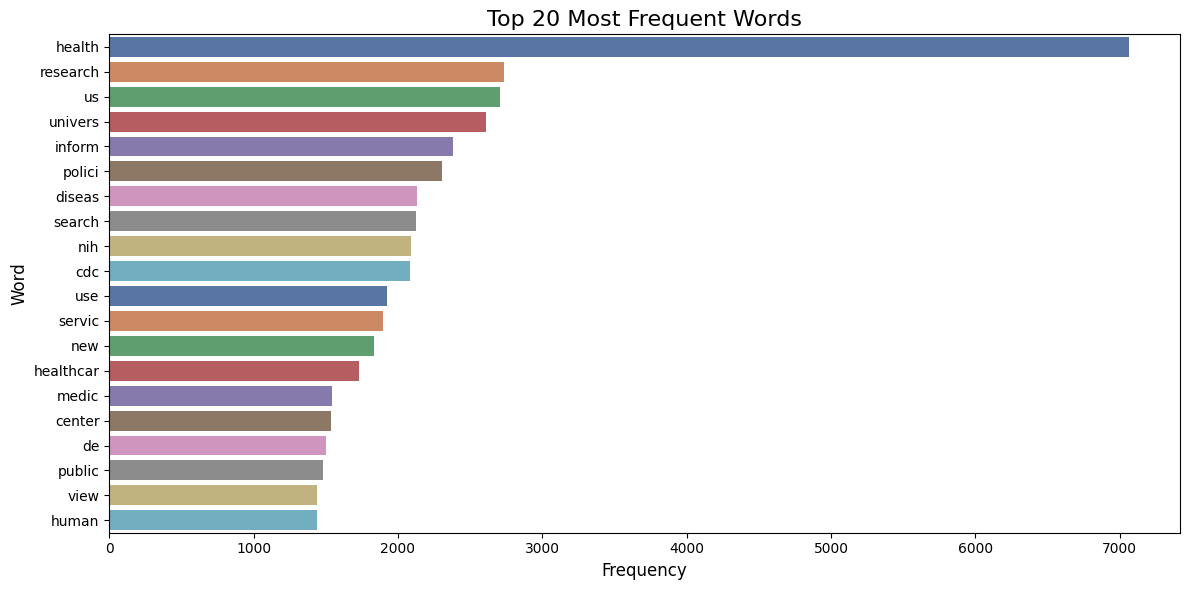

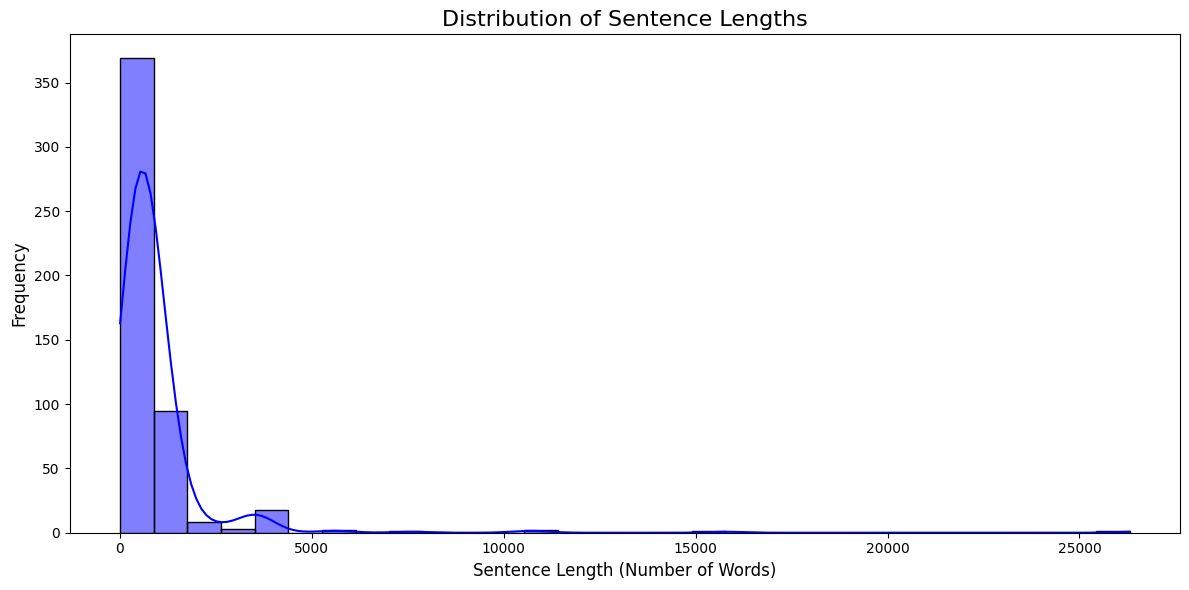

In [13]:
word_frequency_analysis()